# Setup

In [ ]:
object_detection_metadata_path = None
multi_tag_metadata_path = None
ocr_metadata_path = None
audio_metadata_path = None
keyframe_metadata_path = None
save_dir = None

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, save_npz, load_npz
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import cv2
import math
from tqdm import tqdm
import pickle

In [ ]:
dir_path = os.getcwd()
parent_dir_path = os.path.dirname(dir_path)

if not keyframe_metadata_path:
    keyframe_metadata_path = f"{parent_dir_path}/keyframes_metadata.json"

if not object_detection_metadata_path:
    object_detection_metadata_path = f'{parent_dir_path}/object_extraction_metadata.json'
    
if not multi_tag_metadata_path:
    multi_tag_metadata_path = f"{parent_dir_path}/tag_metadata.json"
    
if not ocr_metadata_path:
    ocr_metadata_path = f"{parent_dir_path}/ocr_metadata.json"
    
if not audio_metadata_path:
    audio_metadata_path = f"{parent_dir_path}/audio_metadata.json"
    
if not save_dir:
    save_dir = f'{dir_path}/metadata_encoded'
    

image_dir = f'{parent_dir_path}/data_extraction/transnet/'
os.makedirs(save_dir, exist_ok=True)

# Helper function

In [ ]:
def get_image_size(image_path):
    """
    Detects the width and height of an image using OpenCV.
    
    Args:
        image_path (str): The path to the image file.

    Returns:
        tuple: (width, height) of the image.
    """
    img = cv2.imread(image_path)
    if img is not None:
        height, width = img.shape[:2]
        return width, height
    else:
        raise ValueError("Could not load image from the provided path.")
    
def remove_last_word(sequence):
    parts = sequence.split('_')  # Split the sequence by '_'
    return '_'.join(parts[:-1])   # Rejoin all parts except the last one

def load_metadata(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Object Detection

In [ ]:
class VisualEncoding:
    def __init__(self, classes, row_str="0123456", col_str="abcdefg"):
        self.classes = classes
        self.classes2idx = {class_: i for i, class_ in enumerate(classes)}
        self.n_row = len(row_str)
        self.n_col = len(col_str)

        x_pts = np.linspace(0, 1, self.n_col+1)
        y_pts = np.linspace(0, 1, self.n_row+1)

        self.grid_bboxes = []
        self.grid_labels = []
        for i in range(self.n_row):
            for j in range(self.n_col):
                label = col_str[j] + row_str[i]
                self.grid_bboxes.append(
                    [x_pts[j], y_pts[i], x_pts[j+1], y_pts[i+1]])
                self.grid_labels.append(label)

        self.grid_bboxes = np.array(self.grid_bboxes)

    def visualize_grid(self, image):
        h, w = image.shape[:2]
        for i in range(self.n_row * self.n_col):
            x_start, y_start, x_end, y_end = self.grid_bboxes[i]
            label = self.grid_labels[i]

            start_point = (int(x_start * w), int(y_start * h))
            end_point = (int(x_end * w), int(y_end * h))

            cv2.rectangle(image, start_point, end_point, (0, 255, 0), 2)
            cv2.putText(image, label, (start_point[0] + 5, start_point[1] + 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        return image

    def encode_bboxes(self, bboxes, labels):
        context = []
        for bbox, label in zip(bboxes, labels):
            x, y = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
            grid_idx = np.argmin(
                np.sum((self.grid_bboxes[:, :2] - np.array([x, y]))**2, axis=1))
            context.append(
                f"{self.grid_labels[grid_idx]}{label.replace(' ', '')}")
        return ' '.join(context)

    def encode_classes(self, labels):
        unique_classes, counts = np.unique(labels, return_counts=True)
        context = []
        for unique_class, count in zip(unique_classes, counts):
            for i in range(count):
                context.append(f"{unique_class.replace(' ', '')}{i}")
        return ' '.join(context)

    def encode_numbers(self, labels):
        unique_classes, counts = np.unique(labels, return_counts=True)
        context = [f"{unique_class.replace(' ', '')}{count}" for unique_class, count in zip(
            unique_classes, counts)]
        return ' '.join(context)

## Preprocessing and save data

In [ ]:
# def prepare_data(metadata_object_detection, metadata_keyframe, all_classes, image_dir):
#     bbox_texts = []
#     class_texts = []
#     number_texts = []
#     frame_ids = []
#     encoder = VisualEncoding(all_classes)

#     for frame_id, frame_data in metadata_keyframe.items():
#         for od_id, od_value in metadata_object_detection.items():
#             if remove_last_word(od_id) == frame_id:
#                 image_path = f"{image_dir}/{frame_data['frame_path']}"
#                 img_width, img_height = get_image_size(image_path)
#                 objects = od_value['objects']
#                 bboxes = []
#                 labels = []
#                 for obj, detections in objects.items():
#                     for detection in detections:
#                         bboxes.append(detection['box'])
#                         labels.append(obj)

#                 if bboxes and labels:
#                     bboxes = np.array(bboxes)
#                     # Normalize bboxes using detected image width and height
#                     bboxes[:, [0, 2]] /= img_width  # Normalize x-coordinates by image width
#                     bboxes[:, [1, 3]] /= img_height  # Normalize y-coordinates by image height

#                     bbox_texts.append(encoder.encode_bboxes(bboxes, labels))
#                     class_texts.append(encoder.encode_classes(labels))
#                     number_texts.append(encoder.encode_numbers(labels))
#                 else:
#                     bbox_texts.append('')
#                     class_texts.append('')
#                     number_texts.append('')
#             else:
#                 bbox_texts.append('')
#                 class_texts.append('')
#                 number_texts.append('')

#             frame_ids.append(frame_id)

#     return bbox_texts, class_texts, number_texts, frame_ids

In [ ]:
def od_process_data(metadata_object_detection, metadata_keyframe, encoder, image_dir):
    bbox_texts = []
    class_texts = []
    number_texts = []
    frame_ids = []
    
    for frame_id, frame_data in tqdm(metadata_keyframe.items(), desc="processing frames"):
        for od_id, od_value in metadata_object_detection.items():
            if remove_last_word(od_id) == frame_id:
                image_path = f"{image_dir}/{frame_data['frame_path']}"
                img_width, img_height = get_image_size(image_path)
                objects = od_value['objects']
                bboxes = []
                labels = []
                for obj, detections in objects.items():
                    for detection in detections:
                        bboxes.append(detection['box'])
                        labels.append(obj)

                if bboxes and labels:
                    bboxes = np.array(bboxes)
                    # Normalize bboxes using detected image width and height
                    bboxes[:, [0, 2]] /= img_width  # Normalize x-coordinates by image width
                    bboxes[:, [1, 3]] /= img_height  # Normalize y-coordinates by image height

                    bbox_texts.append(encoder.encode_bboxes(bboxes, labels))
                    class_texts.append(encoder.encode_classes(labels))
                    number_texts.append(encoder.encode_numbers(labels))
                else:
                    bbox_texts.append('')
                    class_texts.append('')
                    number_texts.append('')
            else:
                bbox_texts.append('')
                class_texts.append('')
                number_texts.append('')

            frame_ids.append(frame_id)

    return bbox_texts, class_texts, number_texts, frame_ids

# TF-IDF Vectorization

* vectorizer.pkl:
    * contains vocabulary and IDF (Inverse Document Frequency)
    * Example
```
{
    'vocabulary_': {'person': 0, 'tie': 1, 'car': 2, ...},
    'idf_': [1.2, 1.5, 1.8, ...],
    ...
}
```
* vectors.npz
    * contains vector feature of TF-IDF in each frames
    * Example (when convert to dense matrix)
```
[
  [0.5, 0.8, 0.0, ...],
  [0.0, 0.3, 0.6, ...],
  ...
]
```

In [ ]:
def create_tfidf_vectors(texts, name, output_dir, normalize_vectors=True):
    """
    Creates TF-IDF vectors from a list of texts, normalizes them, and saves the vectorizer and vectors to disk.

    Parameters:
    - texts: List of strings to vectorize.
    - name: A name identifier for saving files.
    - output_dir: Directory to save the vectorizer and vectors.
    - normalize_vectors: Whether to normalize the vectors (default: True).

    Returns:
    - vectorizer: The fitted TfidfVectorizer.
    - vectors: The generated TF-IDF vectors.
    """
    
    # Initialize the TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        min_df=1, analyzer='word', token_pattern=r'\S+')
    
    try:
        vectors = vectorizer.fit_transform(texts)
    except ValueError as e:
        print(f"Warning: Unable to create vectors for {name}. Error: {str(e)}")
        vectorizer = None
        vectors = csr_matrix((len(texts), 0))

    # Optionally normalize the vectors
    if normalize_vectors and vectors.shape[1] > 0:
        vectors = normalize(vectors, norm='l2')
    
    # Save the vectorizer and vectors to disk
    if vectorizer is not None:
        with open(os.path.join(output_dir, f'{name}_vectorizer.pkl'), 'wb') as f:
            pickle.dump(vectorizer, f)

    save_npz(os.path.join(output_dir, f'{name}_vectors.npz'), vectors)

    print(f"{name.capitalize()} vectorization complete. Shape: {vectors.shape}")

    return vectorizer, vectors

# Embedding object detection

In [ ]:
# Object detection
metadata_object_detection = load_metadata(object_detection_metadata_path)
metadata_keyframe = load_metadata(keyframe_metadata_path)
all_classes = list(set(obj for frame in metadata_object_detection.values() if 'objects' in frame for obj in frame['objects'].keys()))
encoder = VisualEncoding(all_classes)

bbox_texts, class_texts, number_texts, frame_ids = od_process_data(metadata_object_detection, metadata_keyframe, encoder, image_dir)
    
bbox_vectorizer, bbox_vectors = create_tfidf_vectors(bbox_texts, 'bbox', save_dir)
class_vectorizer, class_vectors = create_tfidf_vectors(class_texts, 'class', save_dir)
number_vectorizer, number_vectors = create_tfidf_vectors(number_texts, 'number', save_dir)

processing frames: 100%|██████████| 2132/2132 [00:06<00:00, 327.11it/s]


Bbox vectorization complete. Shape: (2935764, 286)
Class vectorization complete. Shape: (2935764, 87)
Number vectorization complete. Shape: (2935764, 84)


In [ ]:
import csv


with open(f'{save_dir}/classes.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Classes'])
    for item in sorted(all_classes):
        writer.writerow([item])

# Test embedding object detection

In [ ]:
def search_similar_frames(query, vectorizers, vectors, frame_ids, top_k=5):
    similarities = []
    for vectorizer, vector in zip(vectorizers, vectors):
        if vectorizer:
            query_vector = vectorizer.transform([query])
            similarity = cosine_similarity(vector, query_vector).flatten()
            similarities.append(similarity)

    if similarities:
        total_similarity = np.sum(similarities, axis=0)
        top_indices = total_similarity.argsort()[-top_k:][::-1]

        results = []
        for idx in top_indices:
            results.append({
                'frame_id': frame_ids[idx],
                'similarity': total_similarity[idx],
            })

        return results
    else:
        return []
    

def visualize_search_results(query, results, visual_encoding, keyframe_metadata, image_dir):
    print(f"\nTop {len(results)} frames similar to query '{query}':")

    n_images = len(results)
    n_cols = min(3, n_images)
    n_rows = math.ceil(n_images / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    if n_images == 1:
        axs = np.array([axs])
    axs = axs.flatten()

    for i, result in enumerate(results):
        print(f"Frame ID: {result['frame_id']}, Similarity: {result['similarity']:.4f}")

        # Load the image
        frame_path = keyframe_metadata[result['frame_id']]['frame_path']
        image_path = os.path.join(image_dir, frame_path)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_with_grid = visual_encoding.visualize_grid(image.copy())

        axs[i].imshow(image_with_grid)
        axs[i].set_title(
            f"Frame ID: {result['frame_id']}\nSimilarity: {result['similarity']:.4f}")
        axs[i].axis('off')

    for j in range(i+1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.suptitle(f"Search Results for Query: '{query}'", fontsize=16, y=1.02)
    plt.show()

In [ ]:
query = "e3tie c1person"
results = search_similar_frames(query, 
                                [bbox_vectorizer, class_vectorizer, number_vectorizer],
                                [bbox_vectors, class_vectors, number_vectors],
                                frame_ids, 
                                top_k=15)

print(results)

[{'frame_id': 'L01_V002_023407', 'similarity': 0.6923389454668009}, {'frame_id': 'L01_V001_031500', 'similarity': 0.6923389454668009}, {'frame_id': 'L01_V002_024152', 'similarity': 0.5324072121555575}, {'frame_id': 'L01_V001_extra_014127', 'similarity': 0.48269143425608274}, {'frame_id': 'L01_V002_000125', 'similarity': 0.44515036772814104}, {'frame_id': 'L01_V002_extra_023408', 'similarity': 0.4430258795911701}, {'frame_id': 'L01_V002_extra_022139', 'similarity': 0.37972057187835856}, {'frame_id': 'L01_V001_023017', 'similarity': 0.36872244366526225}, {'frame_id': 'L01_V002_009487', 'similarity': 0.36496878986822634}, {'frame_id': 'L01_V001_extra_023017', 'similarity': 0.32489607000563453}, {'frame_id': 'L01_V001_extra_023063', 'similarity': 0.32448354685967873}, {'frame_id': 'L01_V002_extra_000687', 'similarity': 0.29138815474413715}, {'frame_id': 'L01_V001_014127', 'similarity': 0.29091751548787975}, {'frame_id': 'L01_V002_extra_000657', 'similarity': 0.2726173497940401}, {'frame_id


Top 15 frames similar to query 'e3tie c1person':
Frame ID: L01_V002_023407, Similarity: 0.6923
Frame ID: L01_V001_031500, Similarity: 0.6923
Frame ID: L01_V002_024152, Similarity: 0.5324
Frame ID: L01_V001_extra_014127, Similarity: 0.4827
Frame ID: L01_V002_000125, Similarity: 0.4452
Frame ID: L01_V002_extra_023408, Similarity: 0.4430
Frame ID: L01_V002_extra_022139, Similarity: 0.3797
Frame ID: L01_V001_023017, Similarity: 0.3687
Frame ID: L01_V002_009487, Similarity: 0.3650
Frame ID: L01_V001_extra_023017, Similarity: 0.3249
Frame ID: L01_V001_extra_023063, Similarity: 0.3245
Frame ID: L01_V002_extra_000687, Similarity: 0.2914
Frame ID: L01_V001_014127, Similarity: 0.2909
Frame ID: L01_V002_extra_000657, Similarity: 0.2726
Frame ID: L01_V002_009662, Similarity: 0.2494


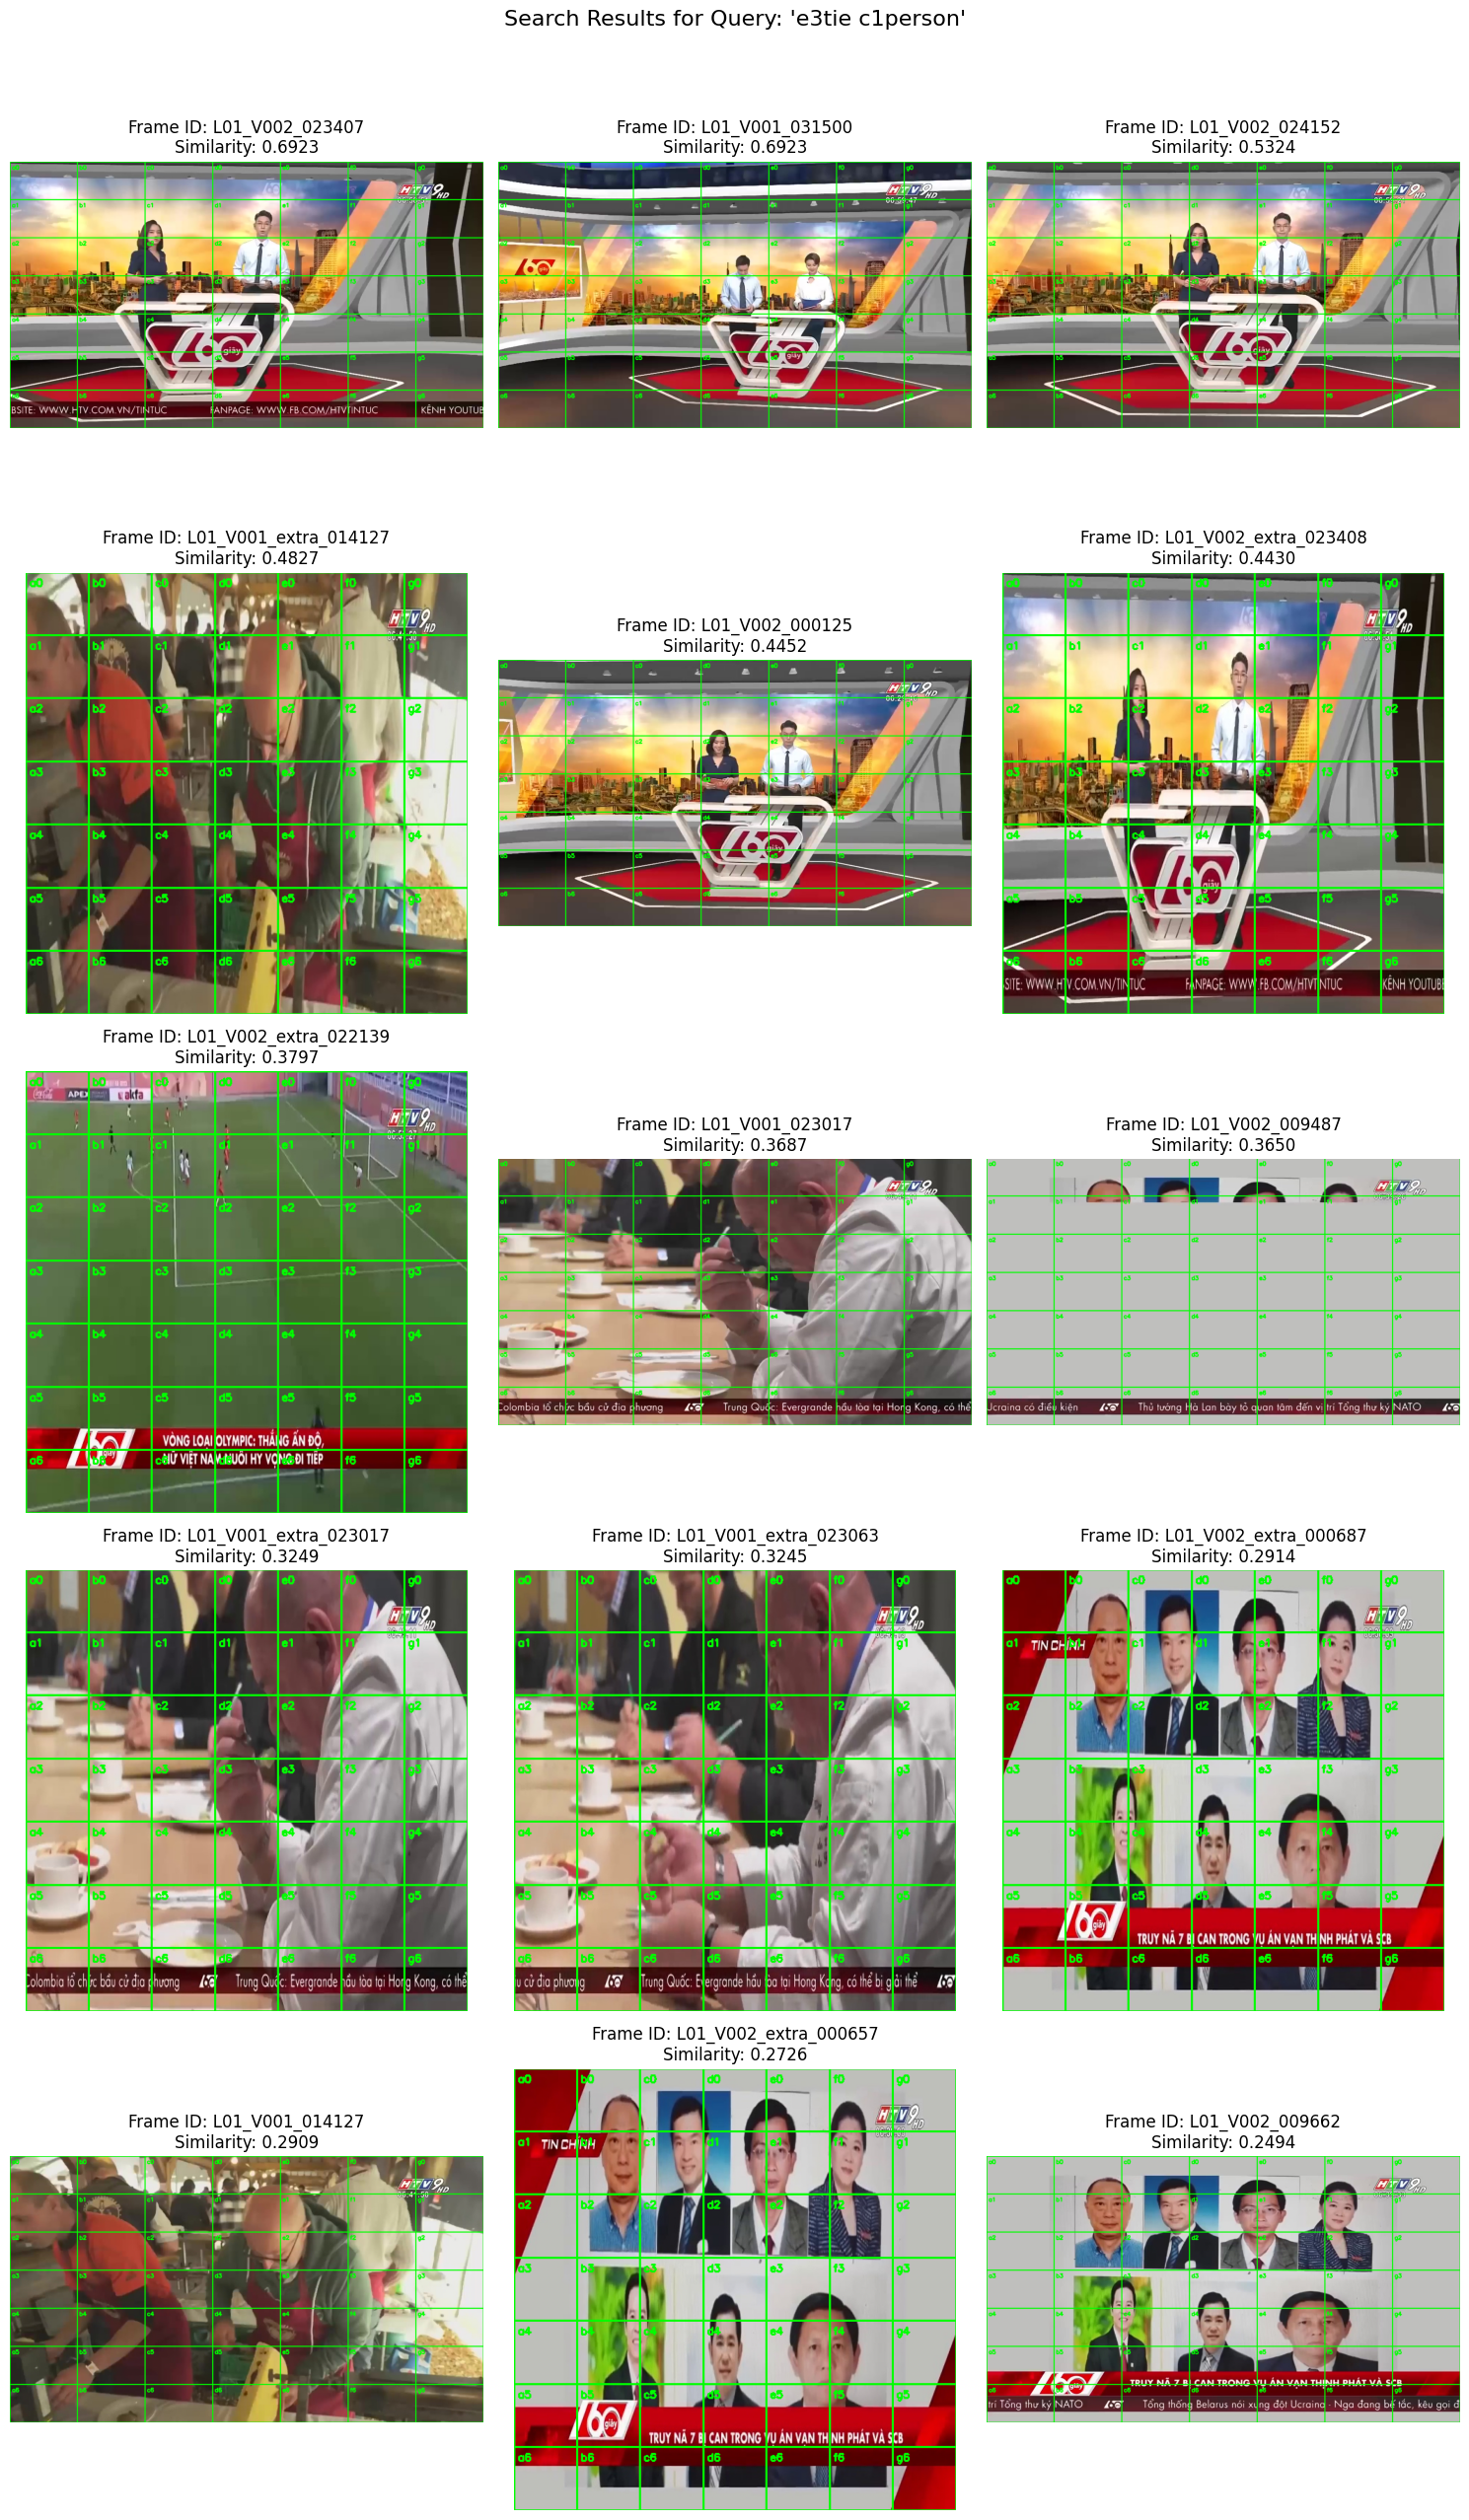

In [ ]:
visualize_search_results(query, results, encoder, metadata_keyframe, image_dir)

# Embedding OCR

In [ ]:
def 